In [1]:
# Author: Pradeep Kumar

# Loading required libraries

import pandas as pd  # Data manipulation and analysis
import numpy as np  # Numerical operations
import seaborn as sns  # Statistical data visualization
import geopandas as gpd  # Geospatial data operations
from collections import Counter  # Count hashable objects
import matplotlib.pyplot as plt  # Plotting library
from shapely.geometry import Point  # Geometric objects for points
from matplotlib import cm  # Colormap and color information
import os  # Operating system interfaces
import warnings  # Warning control
import re  # Regular expression operations
from scipy.stats import pearsonr  # Pearson correlation coefficient

warnings.filterwarnings("ignore")  # Suppress warnings

In [2]:
to_rename = {
    'Beek': 'Beek (L.)',
    'Bergen (L)': 'Bergen (L.)',
    'Bergen (NH)': 'Bergen (NH.)',
    'Hengelo': 'Hengelo (O.)',
    'Laren': 'Laren (NH.)',
    'Middelburg': 'Middelburg (Z.)',
    'Rijswijk': 'Rijswijk (ZH.)',
    'Stein': 'Stein (L.)'
}


In [3]:
# Define base project paths
project_base_path = "G://Projecten//"  # Adjust this path as necessary to match your project directory structure

# Data paths
geolocation_path = f"{project_base_path}/8491_BZK_Meting_stemlokalen/Data/Geolocation/"
wims_processed_path = f"{project_base_path}/Data Science/8577_Meting Stemlokalen Tweede Kamer 2023/Data/WIMS/"
geo_data = f"{project_base_path}/Data Science/8577_Meting Stemlokalen Tweede Kamer 2023/Data/Geolocation/"

# Input files
wims_file = "TweedeKamer-verkiezingen_20231124_DataV1.5_apiupdated_checked_deduplicated_checked_kiesraadappended_checked.xlsx"

# Reading gemeentegrenzen file with relative path
gemeentegrenzen_path = f"{geo_data}gemeente 2023.gml"
gemeentegrenzen = gpd.read_file(gemeentegrenzen_path)
gemeentegrenzen['statnaam'] = gemeentegrenzen['statnaam'].replace(to_rename)

# Output files path
output_file_path = f"{project_base_path}/Data Science/8577_Meting Stemlokalen Tweede Kamer 2023/Results/Tables/"


In [4]:
# Some parameters

fontname = {'fontname':'#3f88cb'}

In [5]:
# Read WIMS dataset
wims_data_all = pd.read_excel(wims_processed_path + wims_file)
print(f"Total number of polling stations: {len(wims_data_all)}")

Total number of polling stations: 9140


In [6]:
# Filter out mobile and special polling stations from the dataset
wims_data = wims_data_all[~wims_data_all['Type stembureau'].isin(['bijzonder', 'mobiel'])]
wims_data = wims_data[['Gemeente', 'CBS gemeentecode', 'Gebruiksdoel van het gebouw', 'Naam stembureau']]
print(f"Total regular polling stations (excluding mobile and special): {len(wims_data)}")
wims_data = wims_data.reset_index(drop=True)

# Calculate normalization factor
normalizing_factor = len(wims_data)

# Clean up 'Gebruiksdoel van het gebouw' column
# 1. Remove 'woonfunctie,' in case of multiple functions including residential
wims_data['Gebruiksdoel van het gebouw'] = wims_data['Gebruiksdoel van het gebouw'].str.replace('woonfunctie,', '')

# 2. Replace '/' with ',' and split the string into a list
wims_data['Gebruiksdoel van het gebouw'] = wims_data['Gebruiksdoel van het gebouw'].str.replace('/', ',').str.split(',')

# 3. Explode the list into separate rows and clean up whitespace and case
wims_data = wims_data.explode('Gebruiksdoel van het gebouw')
wims_data['Gebruiksdoel van het gebouw'] = wims_data['Gebruiksdoel van het gebouw'].str.strip().str.lower()

# Drop rows with missing 'Gebruiksdoel van het gebouw'
wims_data = wims_data.dropna(subset=['Gebruiksdoel van het gebouw'])

# Uncomment to export to Excel
# wims_data.to_excel("D://8491_bzk_meting_stemlokalen//4_output//temp.xlsx")


Total regular polling stations (excluding mobile and special): 8944


## Building Function Overview at National Level

In [7]:
# Extract 'Gebruiksdoel van het gebouw' column values from wims_data and convert to a list
building_functions = wims_data['Gebruiksdoel van het gebouw'].values.tolist()

# Remove leading and trailing spaces from each function
building_functions = [function.strip() for function in building_functions]

# Count occurrences of each function
function_counts = Counter(building_functions)

# Convert the counter object to a DataFrame for further processing
function_count_df = pd.DataFrame.from_dict(function_counts, orient='index').reset_index()

# Rename columns for clarity
function_count_df.rename(columns={'index': 'Gemeente', 0: 'Count Function'}, inplace=True)

# Remove rows with 'geen' or 'onbekend' in 'Gemeente'
function_count_df = function_count_df[~function_count_df.Gemeente.isin(['geen', 'onbekend'])]

# Reset index after filtering
function_count_df.reset_index(drop=True, inplace=True)

# Calculate percentage of each function
function_count_df['Percent'] = function_count_df['Count Function'] * 100 / normalizing_factor

# Remove 'functie' from 'Gemeente' and capitalize each entry
function_count_df['Gemeente'] = function_count_df['Gemeente'].str.replace('functie', '').str.capitalize()

# Sort DataFrame by 'Percent' in descending order
function_count_df.sort_values(by='Percent', ascending=False, inplace=True)

# Save the DataFrame to an Excel file
#function_count_df.to_excel(output_file_path+"nationwide_building_function.xlsx")


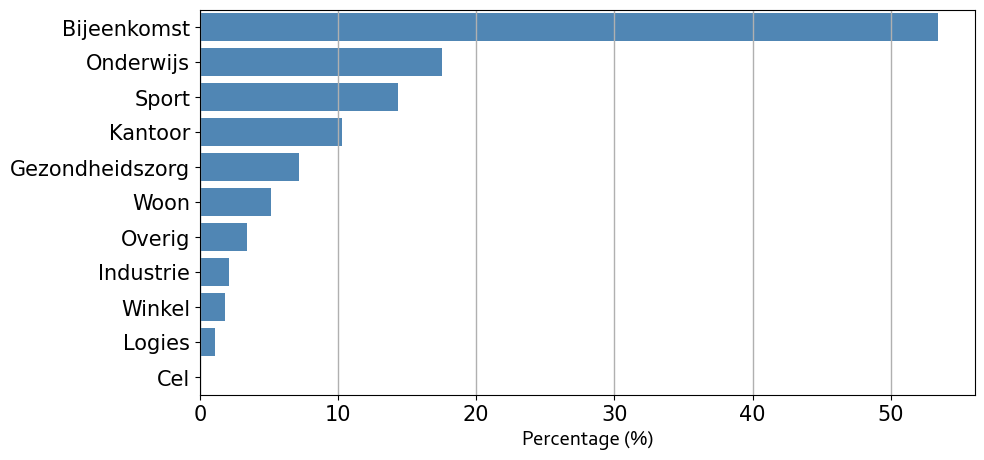

In [8]:
# Set the size of the figure for the plot
plt.rcParams["figure.figsize"] = [10, 5]
# Data preprocessing: Rename a category for clarity
function_count_df['Gemeente'].replace('Overige gebruiks', 'Overig', inplace=True)

# Create a horizontal bar plot
sns.barplot(data=function_count_df, x="Percent", y="Gemeente", orient='h', color = '#3f88c5')  # palette='Blues_r', color = '#3f88c5'

# Define fontdict
fontdict = {
    'fontname': "Corbel",
    'fontsize': 15
}

# Customize the plot with title, labels, and grid
plt.xlabel('Percentage (%)', fontdict= fontdict)
plt.ylabel('', fontsize=15, fontdict= fontdict)
plt.grid(axis='x', linewidth=1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Save the plot as a high-resolution PNG image
plt.savefig("G://Projecten//Data Science//8577_Meting Stemlokalen Tweede Kamer 2023//Results//Graphs//nationwide_building_function.png", format='png', dpi=500, bbox_inches='tight',
transparent=True)
plt.show()

In [9]:
# Count the number of building functions per municipality
function_count_by_gemeente = wims_data.groupby(['CBS gemeentecode', 'Gebruiksdoel van het gebouw']).count().reset_index()
function_count_by_gemeente.rename(columns={'Gemeente': 'Count'}, inplace=True)

# Calculate the percentage of each function per municipality
start = 0
list_gemeente = list(set(wims_data['CBS gemeentecode']))

for gemeente in list_gemeente:
    # Filter data for the current municipality
    temp_gemeente = wims_data[wims_data['CBS gemeentecode'] == gemeente]
    all_function = [fn.strip() for fn in temp_gemeente['Gebruiksdoel van het gebouw'].values.tolist()]
    count_function = Counter(all_function)

    # Create a DataFrame and calculate percentages
    temp_count_all = pd.DataFrame.from_dict(count_function, orient='index').reset_index()
    temp_count_all = temp_count_all.rename(columns={'index': 'Gemeente', 0: 'Count Function'})
    temp_count_all = temp_count_all[~temp_count_all.Gemeente.isin(['geen', 'onbekend'])].reset_index(drop=True)
    temp_count_all['percent'] = temp_count_all['Count Function'] * 100 / temp_count_all['Count Function'].sum()

    # Prepare data for final DataFrame
    temp_count = temp_count_all[['Gemeente', 'percent']].T
    temp_count_abs = temp_count_all[['Gemeente', 'Count Function']].T
    temp_count.columns = temp_count.iloc[0]
    temp_count_abs.columns = temp_count_abs.iloc[0]
    temp_count = temp_count.iloc[1:, :]
    temp_count_abs = temp_count_abs.iloc[1:, :]
    temp_count = temp_count.rename(index={'percent': gemeente})
    temp_count_abs = temp_count_abs.rename(index={'Count Function': gemeente})
    temp_count['Gemeente'] = temp_count.index
    temp_count_abs['Gemeente'] = temp_count_abs.index

    # Combine data for all municipalities
    if start == 0:
        all_gemeente = temp_count
        all_gemeente_abs = temp_count_abs
        start = 1
    else:
        all_gemeente = pd.concat([all_gemeente, temp_count], axis=0)
        all_gemeente_abs = pd.concat([all_gemeente_abs, temp_count_abs], axis=0)

# Clean and finalize the DataFrames
all_gemeente = all_gemeente.fillna(0)
all_gemeente_abs = all_gemeente_abs.fillna(0)

for col in all_gemeente.columns:
    col_new = col.replace('functie', '').capitalize()
    all_gemeente.rename(columns={col: col_new}, inplace=True)
    all_gemeente_abs.rename(columns={col: col_new}, inplace=True)

# Optional: Save the results to an Excel file
#all_gemeente.to_excel(output_file_path+"Municipality_level_building_function.xlsx")


In [10]:
#all_gemeente_abs.drop(columns= ['Gemeente'],inplace = True)

gemeente_boundaries = pd.merge(gemeentegrenzen, all_gemeente,
                               left_on = "statcode", 
                               right_on = "Gemeente")
gemeente_boundaries.rename(columns = {'Overige gebruiks':'Overige'}, inplace= True)


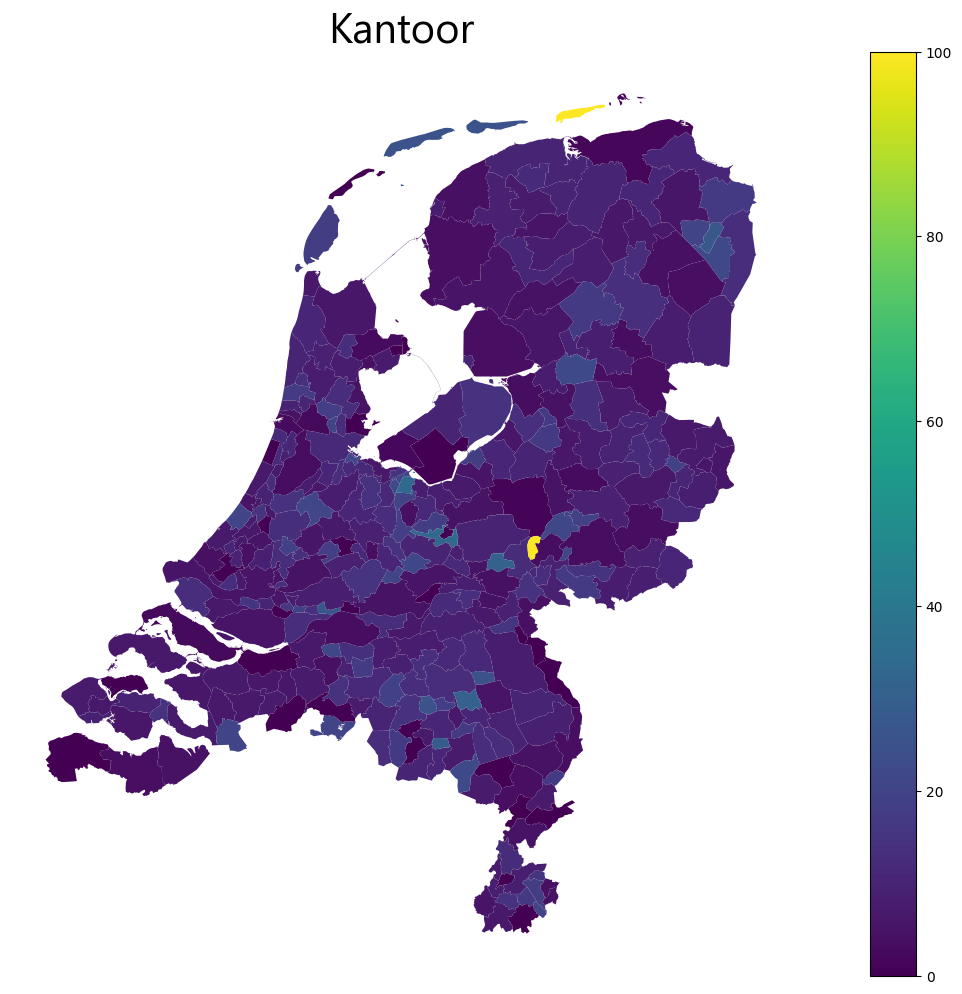

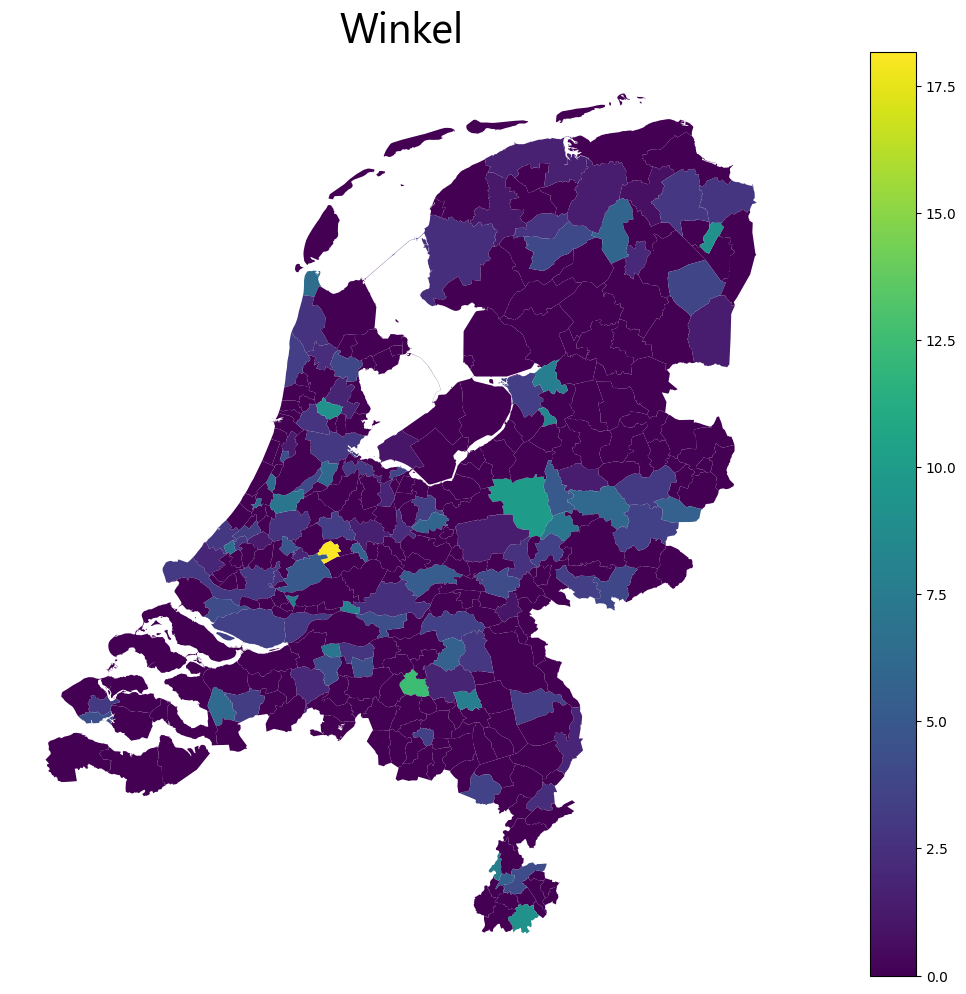

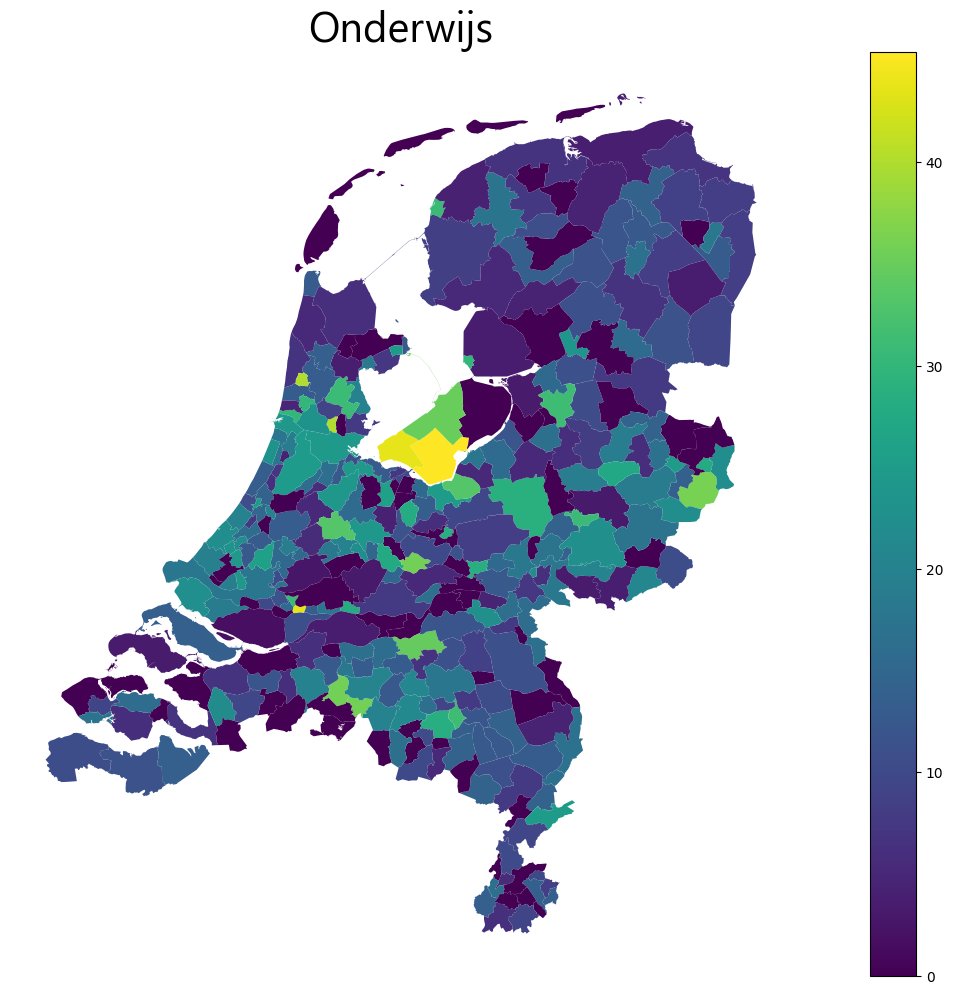

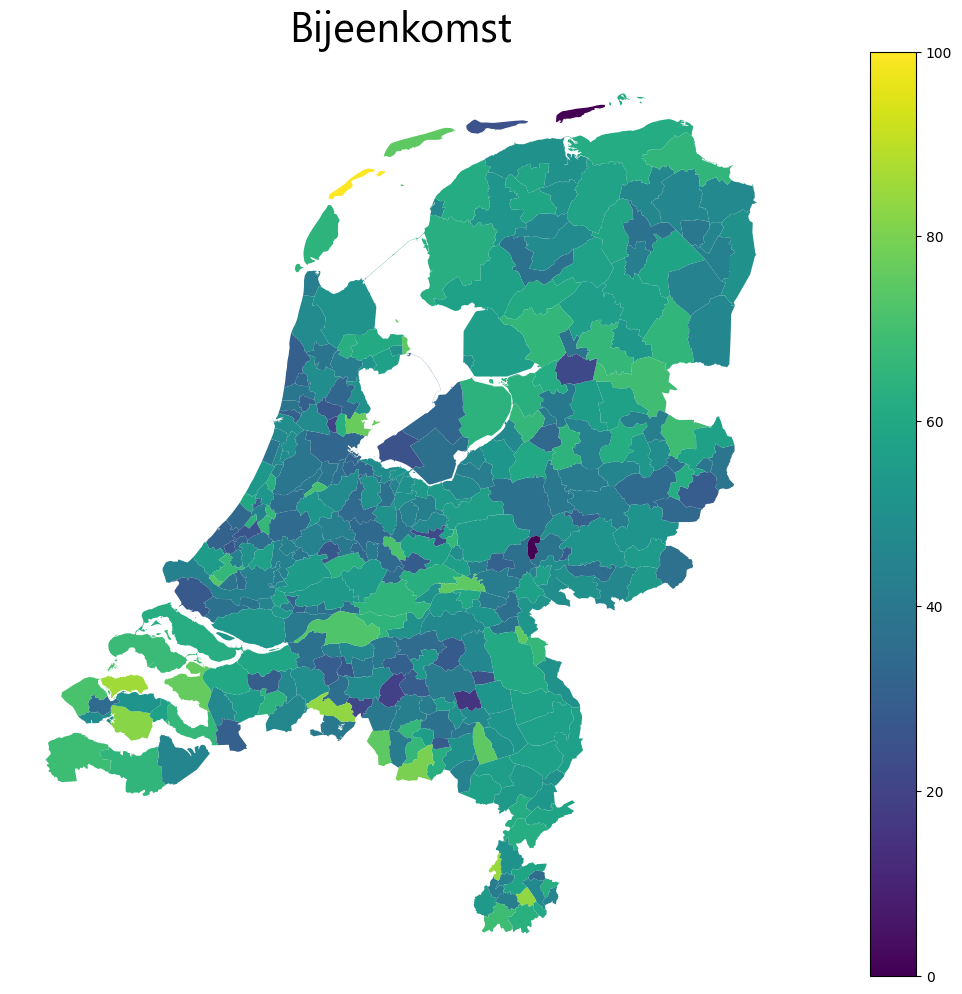

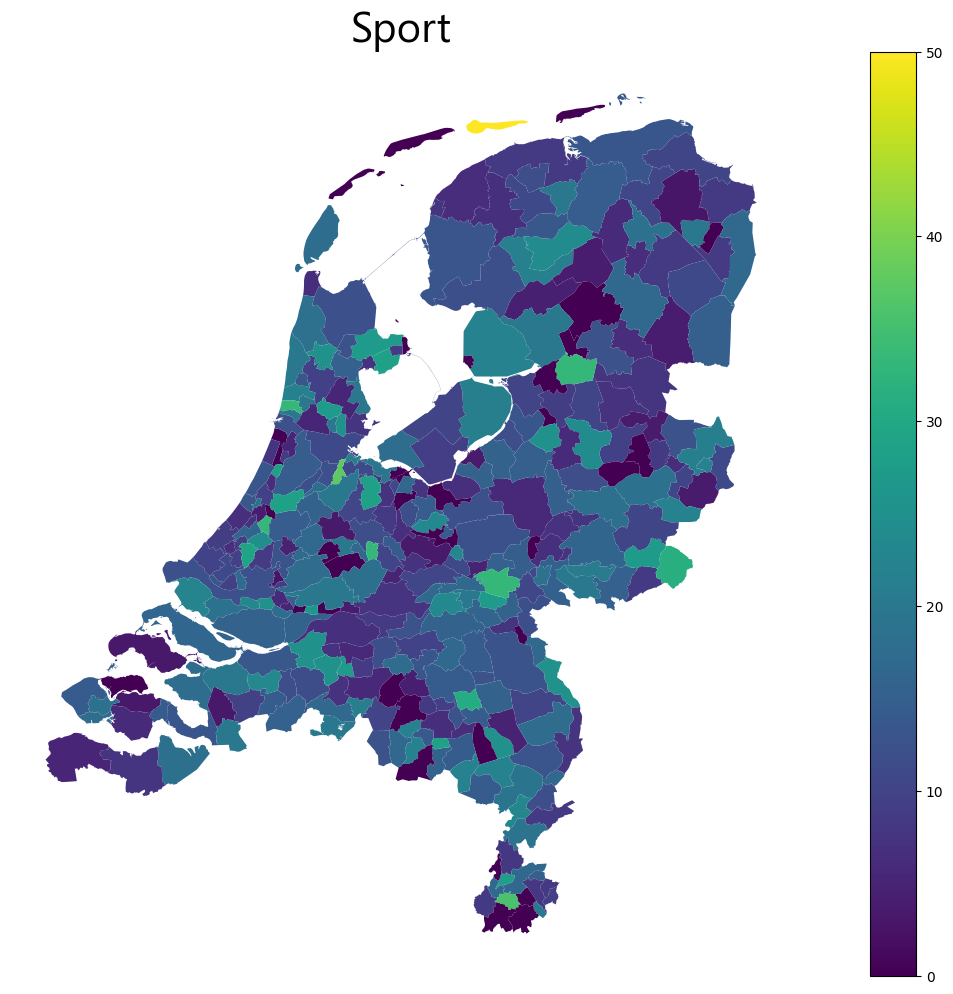

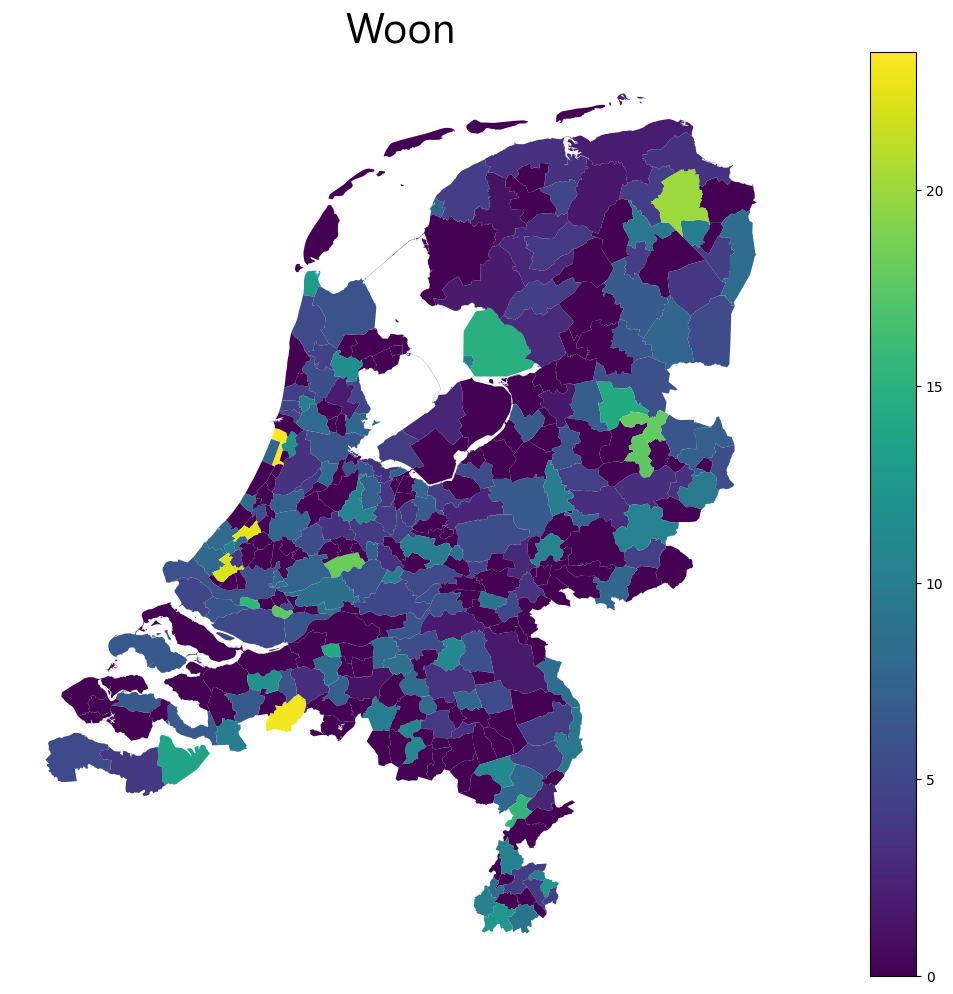

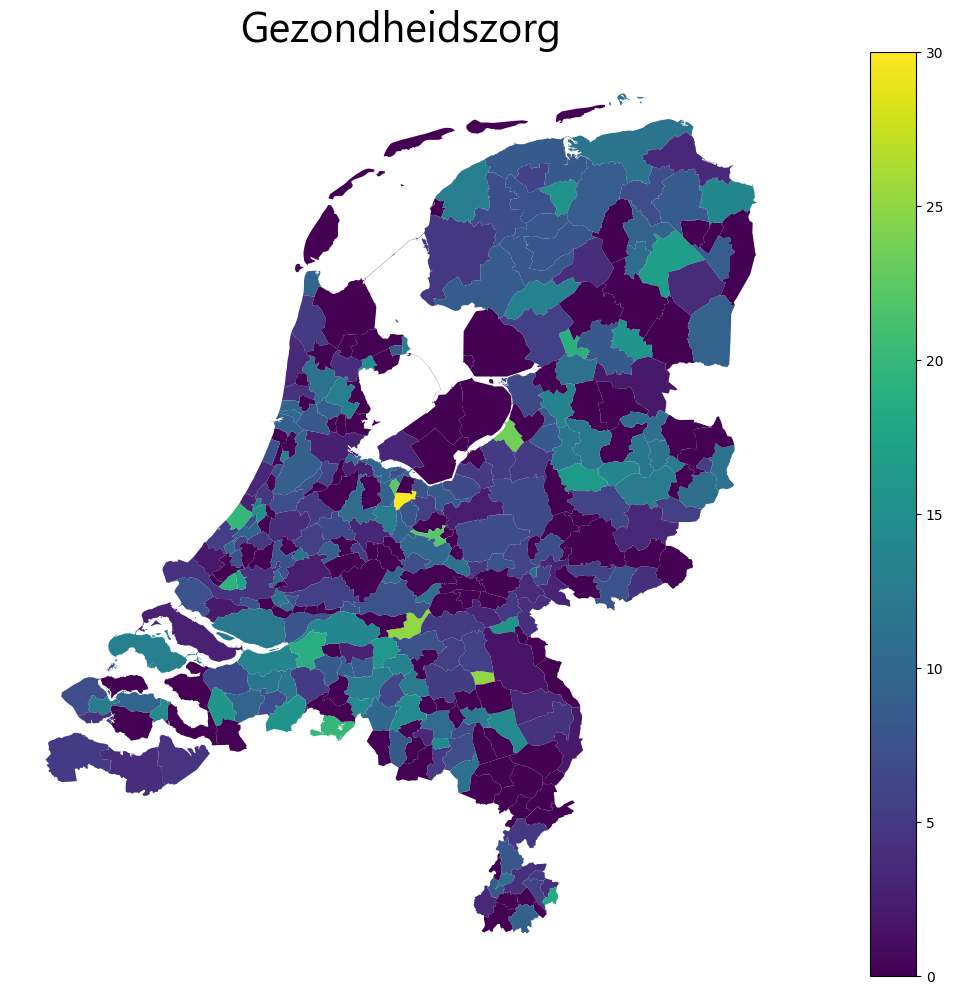

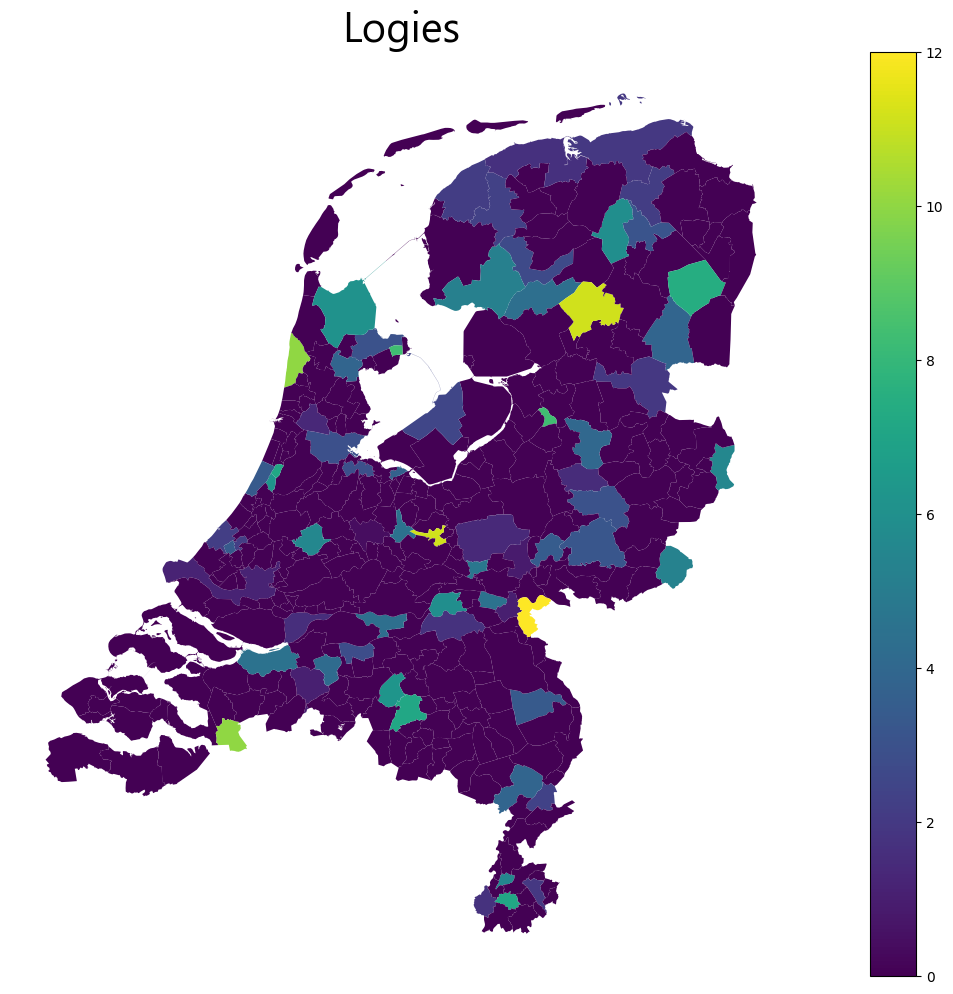

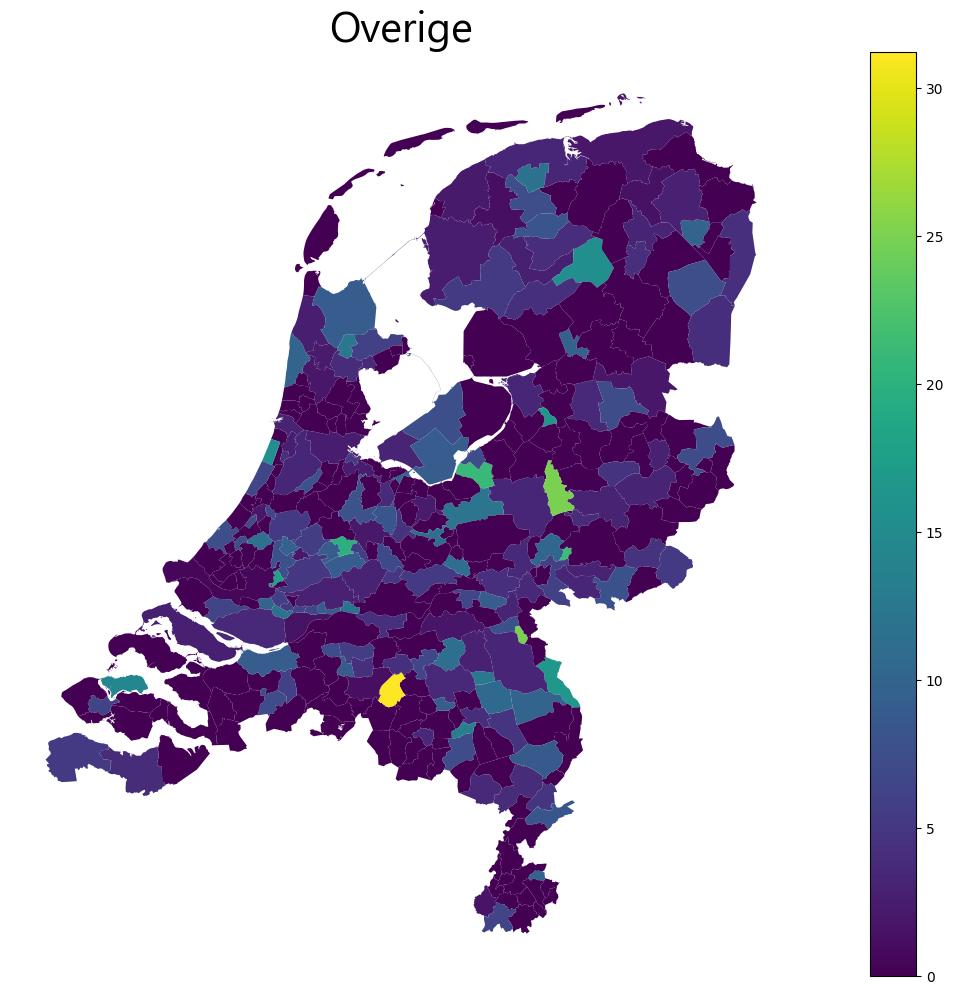

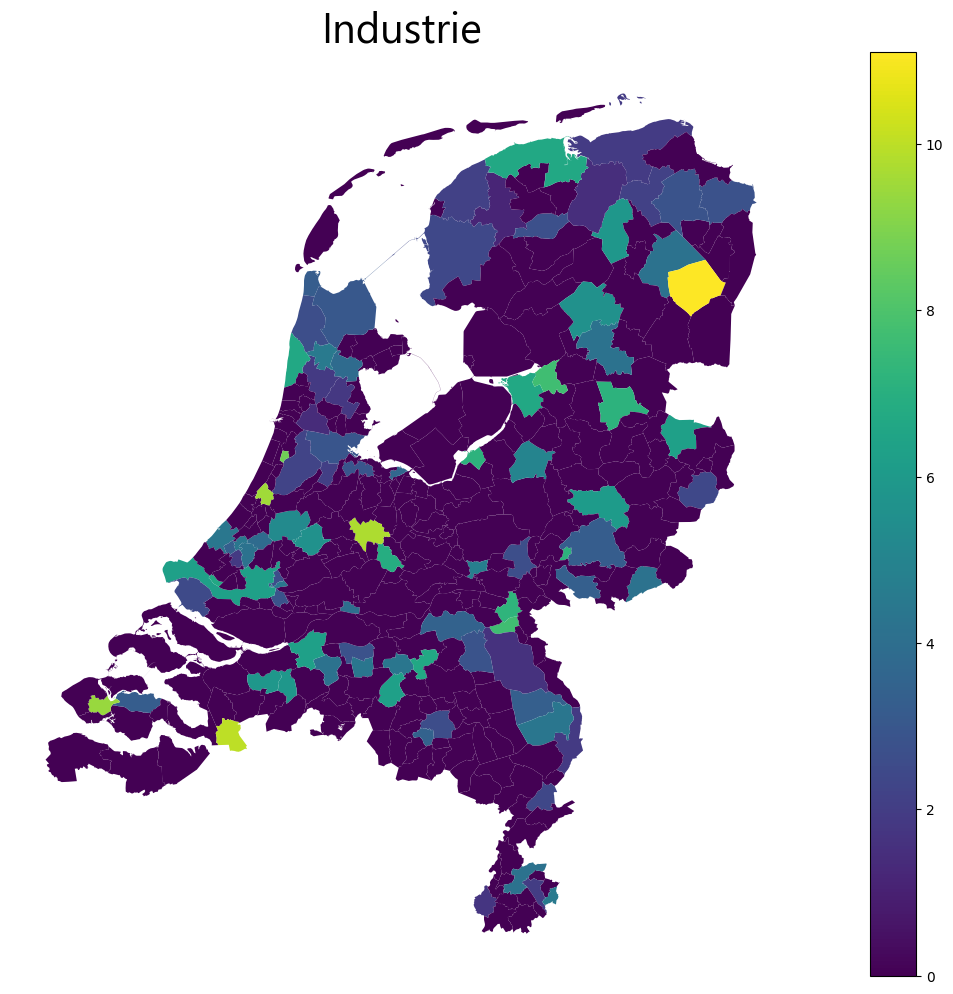

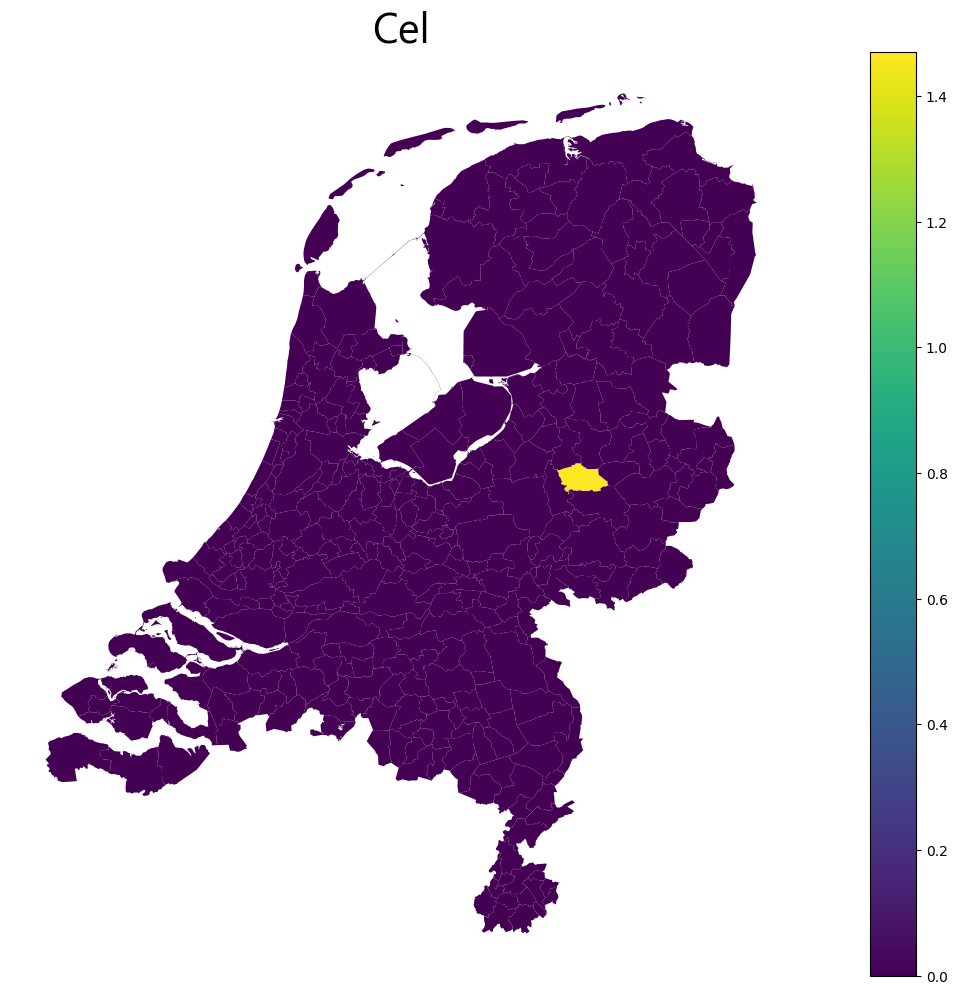

In [11]:
gemeente_boundaries_log_scale = gemeente_boundaries
for fn in ['Kantoor', 'Winkel', 'Onderwijs','Bijeenkomst', 'Sport', 'Woon', 'Gezondheidszorg', 'Logies', \
       'Overige', 'Industrie', 'Cel']:
    
    # converts it logarthmic scale
    #gemeente_boundaries_log_scale[fn]     = gemeente_boundaries_log_scale[fn].fillna(1)
    #gemeente_boundaries_log_scale[fn].replace(0,1, inplace = True,regex=False)
    #gemeente_boundaries_log_scale[fn]     = np.log10(gemeente_boundaries_log_scale[fn])
    #gemeente_boundaries_log_scale[fn]     = gemeente_boundaries_log_scale[fn].fillna(0)
    #p = gemeente_boundaries_log_scale.plot(column= fn, figsize = (20,12), legend = True, markersize = 12, cmap = 'viridis')
    p = gemeente_boundaries.plot(column= fn, figsize = (20,12), legend = True, markersize = 12, cmap = 'viridis')
    fig = p.figure
    cb_ax = fig.axes[0]
    cb_ax.tick_params(labelsize=25)
    p.set_title(fn, fontsize = 30,color = "black",fontname="Segoe UI")
    p.axis('off')
    #plt.savefig("G://Projecten//Data Science//8577_Meting Stemlokalen Tweede Kamer 2023//Results//Graphs//map_"+fn+"_percentage_function_gemeente.svg", format='svg',bbox_inches = 'tight')
    #plt.savefig("G://Projecten//Data Science//8577_Meting Stemlokalen Tweede Kamer 2023//Results//Graphs//map_"+fn+"_percentage_function_gemeente.png", format='png', dpi=500,bbox_inches = 'tight')

## Mean/Median distance for polling station

In [12]:
stem_distance = pd.read_excel("G://Projecten//Data Science//8577_Meting Stemlokalen Tweede Kamer 2023//Analyses//gemeente_level//distances_on_gemeentelevel.xlsx")

In [13]:
stem_distance['gemeentecode'] = stem_distance['gemeentecode'].apply(lambda x: str(x).zfill(4))
stem_distance['gemeente']     = stem_distance['gemeente'].str.strip()

In [14]:
gemeentegrenzen['statnaam']     = gemeentegrenzen['statnaam'].str.strip()

Text(0.5, 1.0, 'Mediane afstand tot stemlokalen')

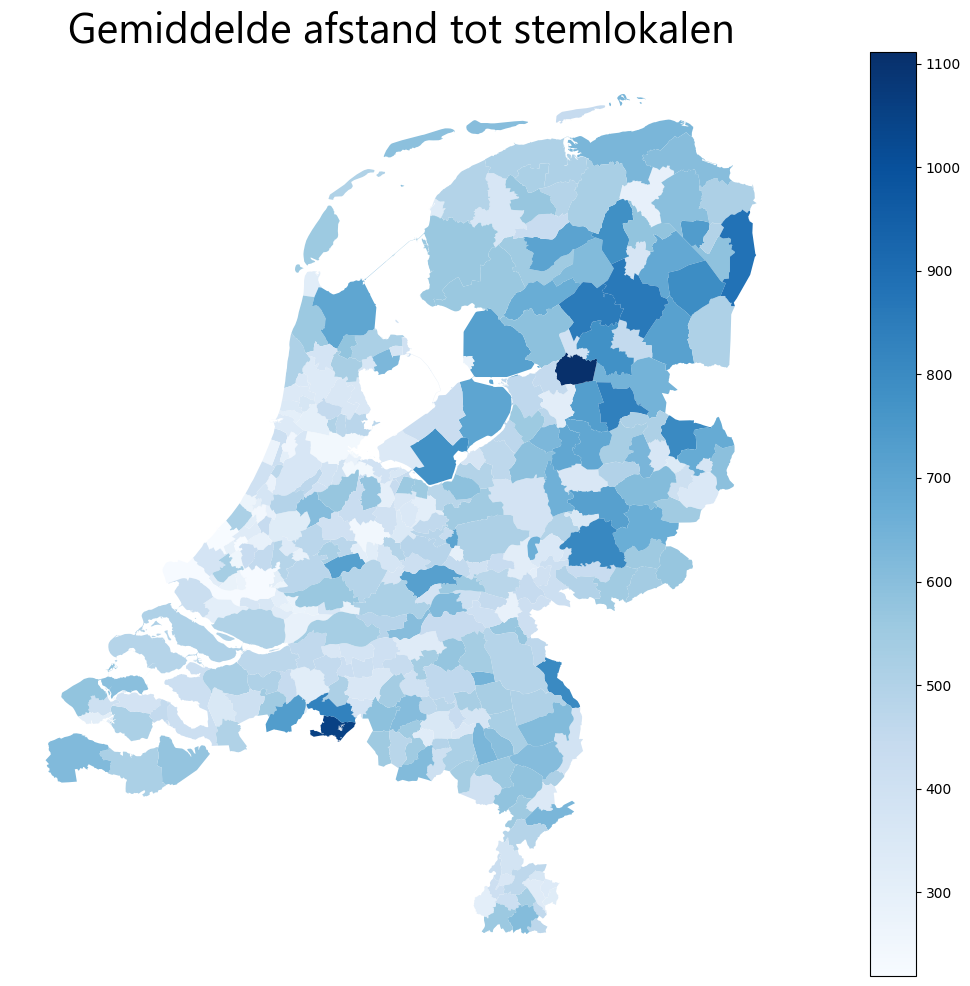

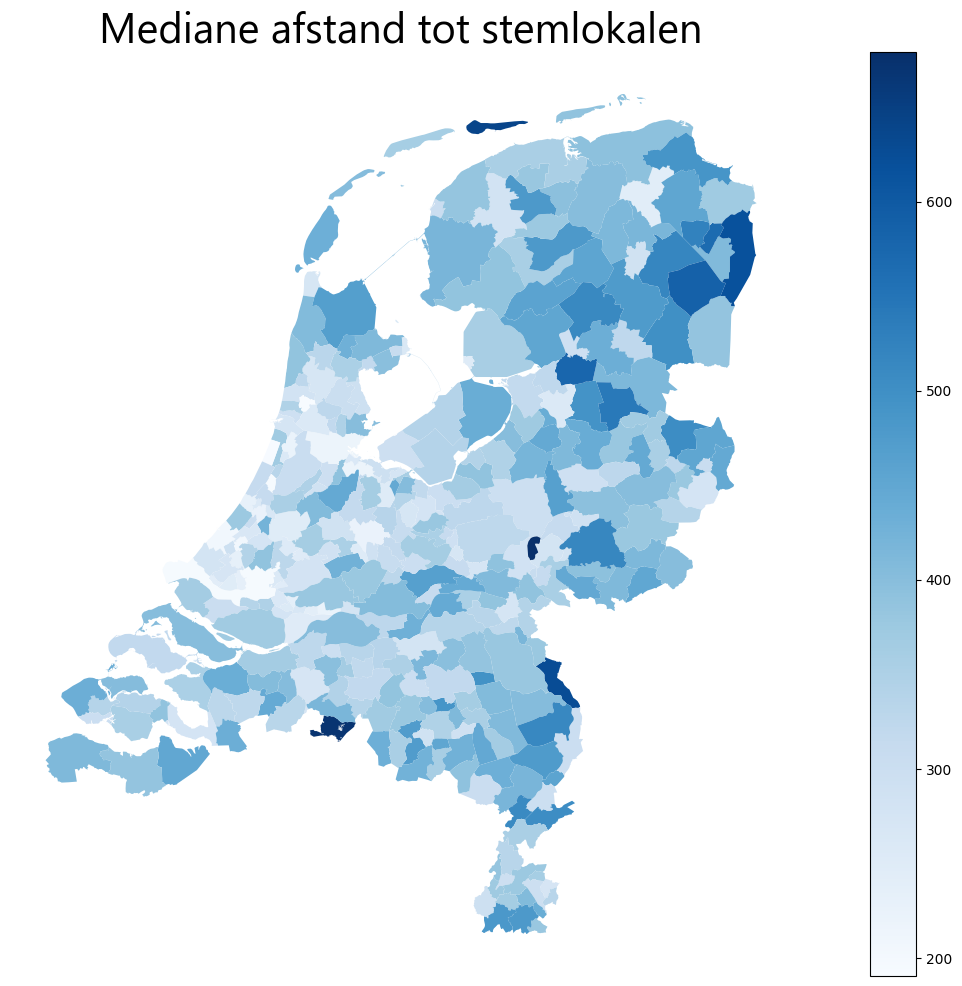

In [15]:
polling_station_distance = pd.merge(gemeentegrenzen,stem_distance,left_on= 'statnaam', right_on='gemeente')

#plt.rcParams["figure.figsize"] = [10,5]

# Mean distance

p = polling_station_distance.plot(column= 'dist_mean', figsize = (20,12), legend = True, markersize = 12, cmap = 'Blues')
fig = p.figure
cb_ax = fig.axes[0]
cb_ax.tick_params(labelsize=25)
p.axis('off')

p.set_title('Gemiddelde afstand tot stemlokalen', fontsize = 30,color = "black",fontname="Segoe UI")
#plt.savefig("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Results//Graphs//map_mean_distance_polling_station.svg", format='svg',bbox_inches = 'tight')
plt.savefig("G://Projecten//Data Science//8577_Meting Stemlokalen Tweede Kamer 2023//Results//Graphs//map_mean_distance_polling_station.png", format='png', dpi=500,bbox_inches = 'tight')

# Median distance

p = polling_station_distance.plot(column= 'dist_median', figsize = (20,12), legend = True, markersize = 12, cmap = 'Blues')
fig = p.figure
cb_ax = fig.axes[0]
cb_ax.tick_params(labelsize=25)
p.axis('off')

p.set_title('Mediane afstand tot stemlokalen', fontsize = 30,color = "black",fontname="Segoe UI")
#plt.savefig("G://Projecten//Data Science//8577_Meting Stemlokalen Tweede Kamer 2023//Results//Graphs//map_median_distance_polling_station.svg", format='svg',bbox_inches = 'tight')
#plt.savefig("G://Projecten//Data Science//8577_Meting Stemlokalen Tweede Kamer 2023//Results//Graphs//map_median_distance_polling_station.png", format='png', dpi=500,bbox_inches = 'tight')


## Overview of Pooling station 

In [16]:
def remove_parentheses(s):
    return re.sub(r'\(.*?\)', '', s)

population_density = pd.read_excel("C://Users//CentERdata//Desktop//Population_density.xlsx", skiprows = 1 )
population_density['CBS code'] = population_density['CBS code'].astype(str).str.zfill(4)
population_density['GM_code'] = 'GM' + population_density['CBS code'].astype(str)
population_density = population_density[['GM_code','Population density']]
population_density['Population density']= population_density['Population density'].apply(remove_parentheses)
population_density['Population density'] = population_density['Population density'].str.replace('/km', '', regex=False)
population_density['Population density'] = population_density['Population density'].str.replace(',', '').str.strip().astype(float)
#population_density['Population density'] = (population_density['Population density'].astype(float)-population_density['Population density'].astype(float).min())/population_density['Population density'].astype(float).max()
#population_density['Population density'] = (population_density['Population density'].astype(float))/population_density['Population density'].astype(float).max()
population_density['Population density'] = np.log(population_density['Population density'])
population_density

GM_code  Population density
0    GM1680            4.532599
1    GM0358            7.405496
2    GM0197            5.641907
3    GM0059            5.616771
4    GM0482            7.749322
..      ...                 ...
337  GM0879            5.231109
338  GM0301            7.078342
339  GM1896            5.648974
340  GM0642            7.703910
341  GM0193            7.086738

[342 rows x 2 columns]

In [17]:
wims_data_all_na = wims_data_all[wims_data_all.Longitude>0]
#wims_data_all_na = pd.merge(wims_data_all_na,population_density, left_on = 'CBS gemeentecode',right_on = 'GM_code')
#wims_data_all_na.shape

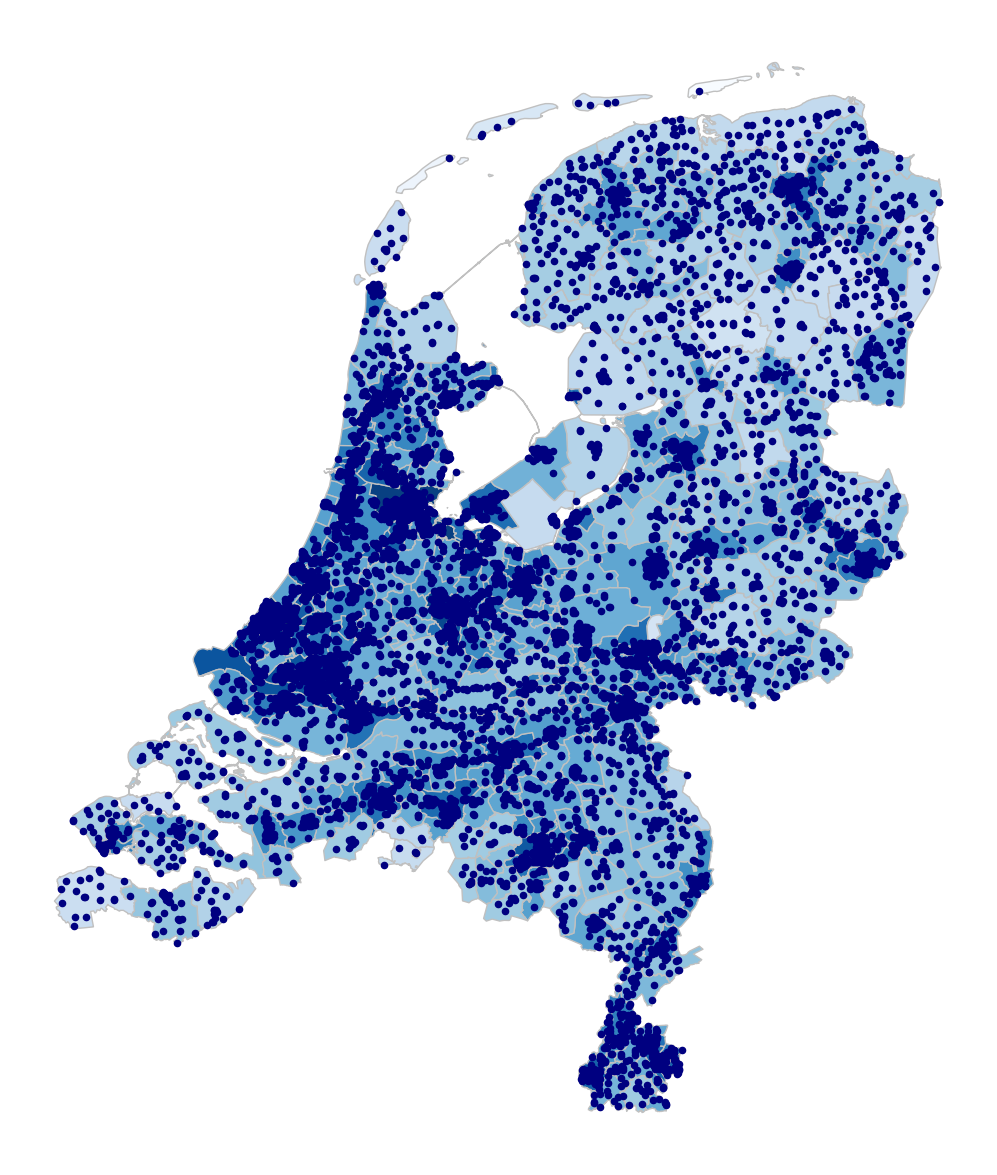

In [18]:
#geometry   = [Point(xy) for xy in zip(wims_data_all['Longitude'], wims_data_all['Latitude'])]

gdf = gpd.GeoDataFrame(gemeentegrenzen)
wims_data_all_na = wims_data_all[wims_data_all.Longitude>0]
wims_data_all_na = pd.merge(wims_data_all_na,population_density, left_on = 'CBS gemeentecode',right_on = 'GM_code')
gdf = gdf.to_crs(epsg=4326)
gdf = pd.merge(gdf,population_density, left_on = 'statcode',right_on = 'GM_code')
fig, ax = plt.subplots(figsize = (15,15))
#gdf.plot(ax=ax, color='lightgrey',edgecolor='silver')
gdf.plot(ax=ax, column='Population density', cmap='Blues', edgecolor='silver', legend=False)
plt.scatter('Longitude','Latitude', s=20, data= wims_data_all_na  # Color of points based on 'Value' column
            ,color ='navy')
plt.axis('off')
#plt.savefig("G://Projecten//Data Science//8577_Meting Stemlokalen Tweede Kamer 2023//Results//Graphs//map_Overview_polling_station.svg", format='svg',bbox_inches = 'tight')
plt.savefig("G://Projecten//Data Science//8577_Meting Stemlokalen Tweede Kamer 2023//Results//Graphs//map_Overview_polling_station_population_density.png", format='png', dpi=500,bbox_inches = 'tight')

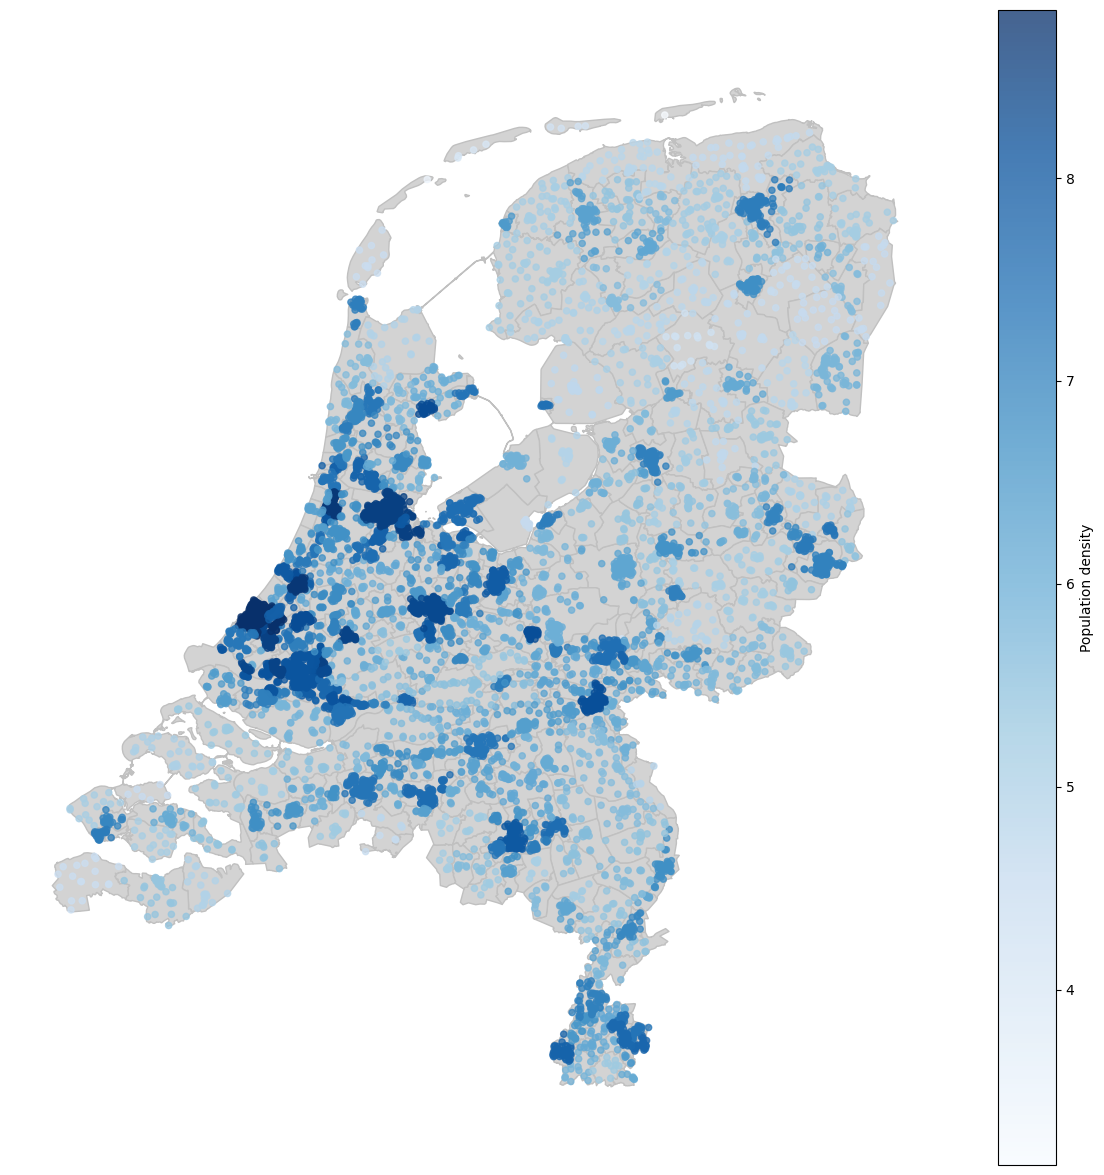

In [19]:
fig, ax = plt.subplots(figsize=(15, 15))
gdf.plot(ax=ax, color='lightgrey', edgecolor='silver')

# Directly pass the column for 'c'. Make sure 'Value' is replaced with your actual column name.
# This ensures that the column's values are used for the color gradient.
scatter = ax.scatter(wims_data_all_na['Longitude'], wims_data_all_na['Latitude'], 
                     s=20, c=wims_data_all_na['Population density'],  # Ensure 'Value' is your column name
                     cmap='Blues', alpha=0.75)

plt.colorbar(scatter, label='Population density')  # Show color scale
plt.axis('off')
plt.show()

##  Based on Opening time

In [20]:
wims_data_all['Openingstijd']      = pd.to_datetime(wims_data_all['Openingstijd'])
wims_data_all['Sluitingstijd']     = pd.to_datetime(wims_data_all['Sluitingstijd'])
wims_data_all['Openingsduur']      = round( (wims_data_all['Sluitingstijd'] - wims_data_all['Openingstijd'])/np.timedelta64(1,'h'),1 )

wims_data_all['Openingsduur_type'] = np.where(
    wims_data_all['Openingsduur'] == 13.5, 'Openingsduur regulier', np.where(
    wims_data_all['Openingsduur'] >  13.5, 'Openingsduur langer dan regulier', 'Openingsduur korter dan regulier')) 

stem_loken_opening_time = wims_data_all.groupby(['Gemeente','Openingsduur_type']).count().reset_index()[['Gemeente','Openingsduur_type','Naam stembureau']]
stem_loken_opening_time

Gemeente                 Openingsduur_type  Naam stembureau
0       's-Gravenhage  Openingsduur korter dan regulier               10
1       's-Gravenhage  Openingsduur langer dan regulier                2
2       's-Gravenhage             Openingsduur regulier              259
3    's-Hertogenbosch  Openingsduur langer dan regulier                1
4    's-Hertogenbosch             Openingsduur regulier               77
..                ...                               ...              ...
432       Zwijndrecht  Openingsduur korter dan regulier                3
433       Zwijndrecht  Openingsduur langer dan regulier                1
434       Zwijndrecht             Openingsduur regulier               14
435            Zwolle  Openingsduur korter dan regulier                5
436            Zwolle             Openingsduur regulier               66

[437 rows x 3 columns]

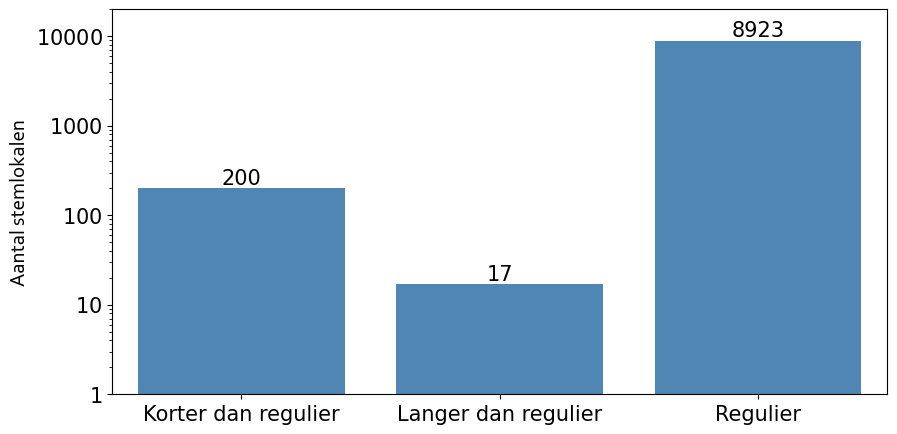

In [21]:
plt.rcParams['axes.formatter.min_exponent'] = 5
pie_chart                 = stem_loken_opening_time.groupby(['Openingsduur_type']).sum().reset_index()
pie_chart['stembureau percentage'] = pie_chart['Naam stembureau']*100/pie_chart['Naam stembureau'].sum()
pie_chart.replace('Openingsduur korter dan regulier','Korter dan regulier',inplace= True)
pie_chart.replace('Openingsduur langer dan regulier','Langer dan regulier',inplace= True)
pie_chart.replace('Openingsduur regulier','Regulier',inplace= True)
# declaring exploding pie
explode = [0.2, 0.2, 0.2]
# define Seaborn color palette to use
palette_color = sns.color_palette('deep')
fig = plt.figure()  
ax = sns.barplot(data=pie_chart,x='Openingsduur_type',y='Naam stembureau',color = '#3f88c5')  #'navy'

ax.set_yscale("log")
ax.set_ylim(1e0,2e4)
plt.xlabel('',fontdict)
plt.ylabel('Aantal stemlokalen',fontdict)
# label.
for i in ax.containers:
    ax.bar_label(i,fontsize=15)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

#fig.savefig("G://Projecten//Data Science//8577_Meting Stemlokalen Tweede Kamer 2023//Results//Graphs//polling_sataion_count.svg", format='svg',bbox_inches = 'tight')
fig.savefig("G://Projecten//Data Science//8577_Meting Stemlokalen Tweede Kamer 2023//Results//Graphs//polling_sataion_count.png", format='png', dpi=500,bbox_inches = 'tight', transparent = True)

In [22]:
Gemeente_different_not_normal_time = stem_loken_opening_time.loc[stem_loken_opening_time.Openingsduur_type!='Openingsduur regulier']
gemeente_not_normal_time_list      = list(Gemeente_different_not_normal_time['Gemeente'])
gemeente_not_normal_time           = stem_loken_opening_time.loc[stem_loken_opening_time['Gemeente'].isin(gemeente_not_normal_time_list)]
gemeente_not_normal_time           = gemeente_not_normal_time.groupby(['Gemeente','Openingsduur_type']).sum().reset_index()
print(gemeente_not_normal_time)
unique_gemeente_name_with_not_normal_time = list(set(gemeente_not_normal_time.Gemeente))

gemeente_with_not_normal_time = pd.DataFrame()

for gm in unique_gemeente_name_with_not_normal_time:
    tempDF             = gemeente_not_normal_time.loc[gemeente_not_normal_time.Gemeente==gm]
    tempDF['Percent']  = tempDF['Naam stembureau']*100/tempDF['Naam stembureau'].sum()
    gemeente_with_not_normal_time = pd.concat([gemeente_with_not_normal_time,tempDF])

             Gemeente                 Openingsduur_type  Naam stembureau
0       's-Gravenhage  Openingsduur korter dan regulier               10
1       's-Gravenhage  Openingsduur langer dan regulier                2
2       's-Gravenhage             Openingsduur regulier              259
3    's-Hertogenbosch  Openingsduur langer dan regulier                1
4    's-Hertogenbosch             Openingsduur regulier               77
..                ...                               ...              ...
173       Zwijndrecht  Openingsduur korter dan regulier                3
174       Zwijndrecht  Openingsduur langer dan regulier                1
175       Zwijndrecht             Openingsduur regulier               14
176            Zwolle  Openingsduur korter dan regulier                5
177            Zwolle             Openingsduur regulier               66

[178 rows x 3 columns]


In [23]:
gemeente_with_not_normal_time[gemeente_with_not_normal_time['Gemeente']=="'s-Gravenhage"]

Gemeente                 Openingsduur_type  Naam stembureau    Percent
0  's-Gravenhage  Openingsduur korter dan regulier               10   3.690037
1  's-Gravenhage  Openingsduur langer dan regulier                2   0.738007
2  's-Gravenhage             Openingsduur regulier              259  95.571956

In [24]:
gemeente_with_not_normal_time[gemeente_with_not_normal_time['Gemeente']=="Vaals"]

Gemeente                 Openingsduur_type  Naam stembureau  Percent
154    Vaals  Openingsduur korter dan regulier                6    100.0

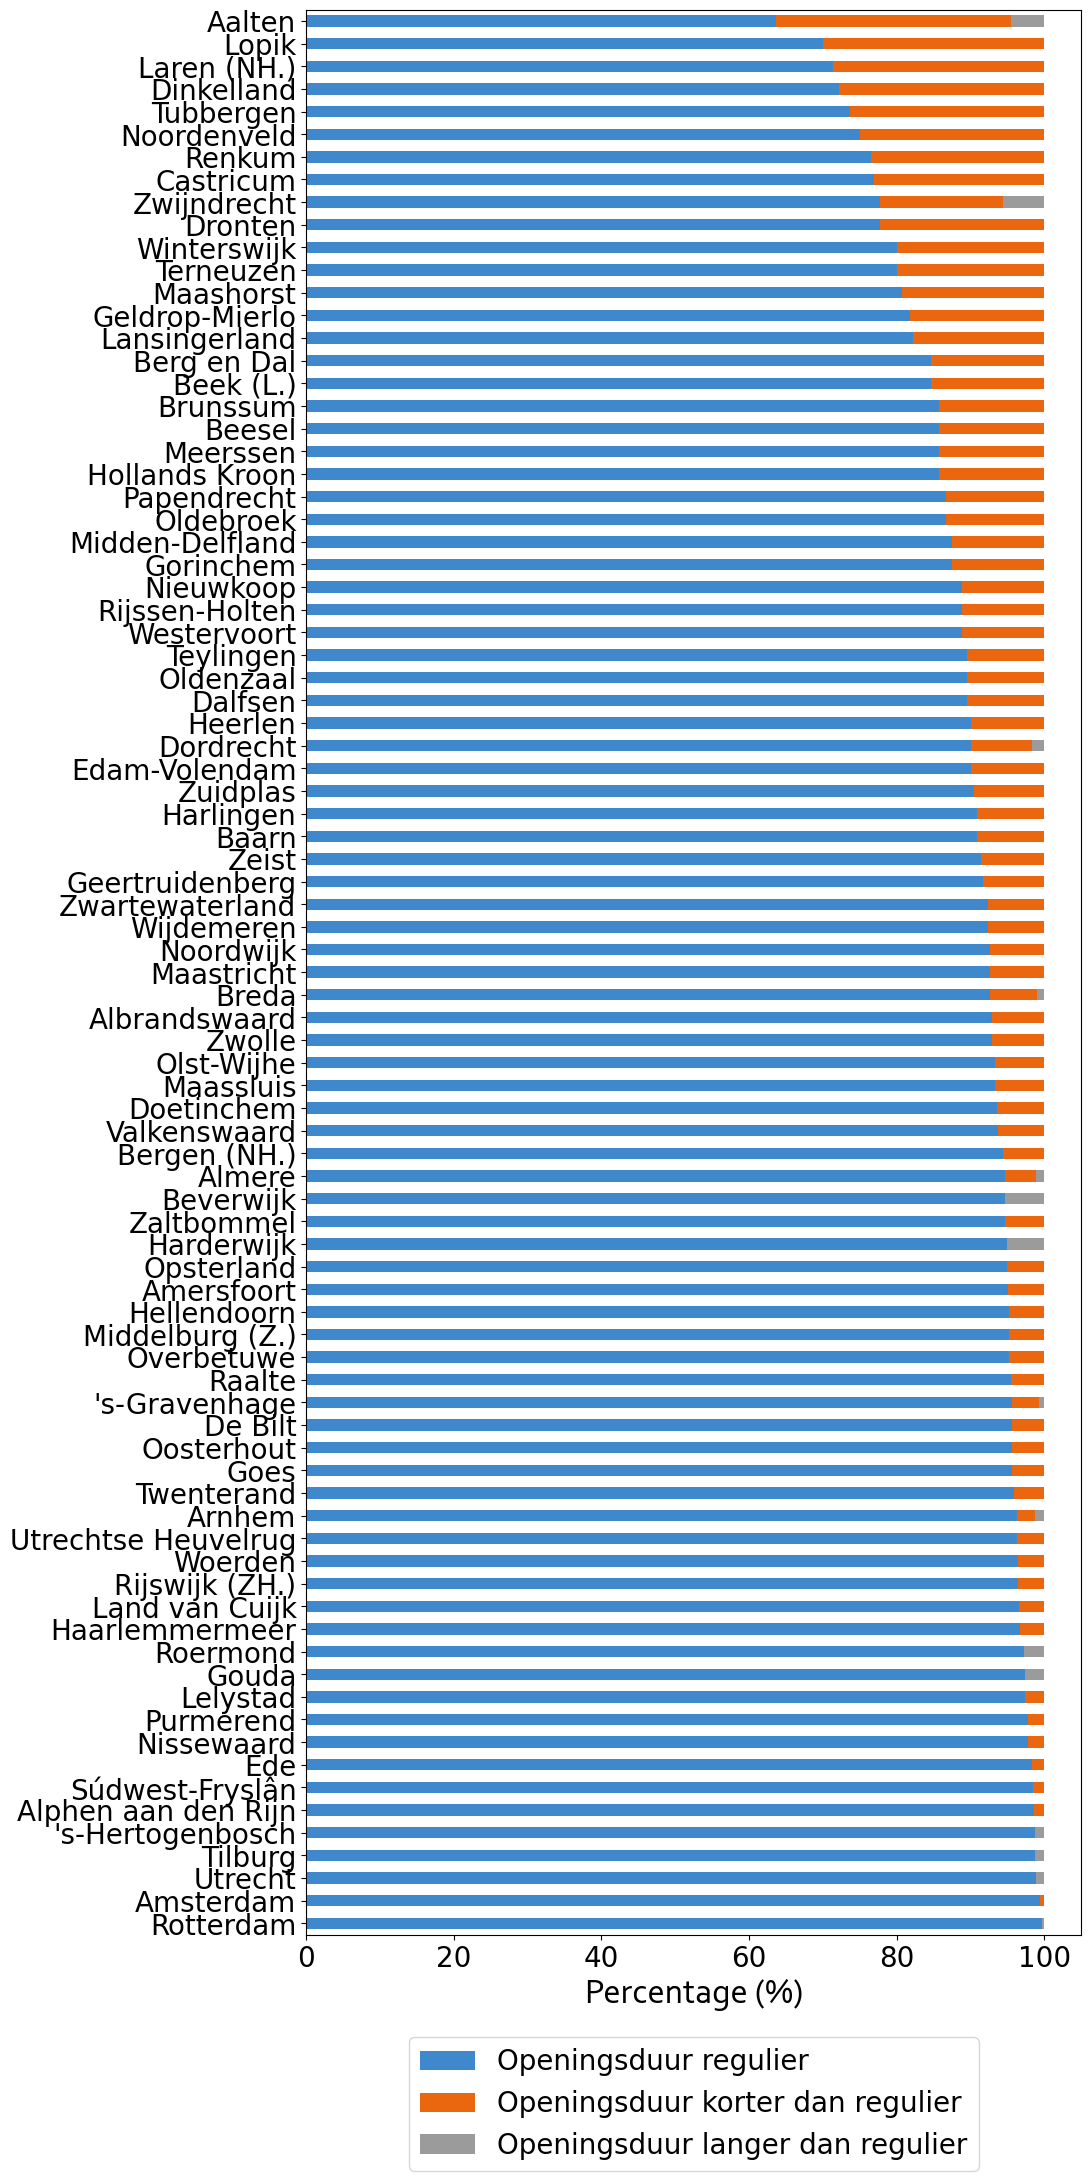

In [25]:
# create stacked bar chart for monthly temperatures
gemeente_with_not_normal_time = gemeente_with_not_normal_time[['Gemeente','Openingsduur_type','Percent']]
gemeente_with_not_normal_time = gemeente_with_not_normal_time[gemeente_with_not_normal_time['Gemeente']!="Vaals"]
gemeente_with_not_normal_time_plot = pd.DataFrame()

unique_gemeente_name_with_not_normal_time = list(set(gemeente_with_not_normal_time.Gemeente))

gemeente                            = []
Openingsduur_afwijkend              = []
Openingsduur_korter_dan_regulier    = []
Openingsduur_langer_dan_regulier    = []

for gm in unique_gemeente_name_with_not_normal_time:
    gemeente.append(gm)
    temp_df = gemeente_with_not_normal_time[gemeente_with_not_normal_time.Gemeente==gm]
    try:
        Openingsduur_afwijkend.append(float(temp_df[temp_df['Openingsduur_type']=='Openingsduur regulier']['Percent']))
    except:
        Openingsduur_afwijkend.append(0)
    try:
        Openingsduur_korter_dan_regulier.append(float(temp_df[temp_df['Openingsduur_type']=='Openingsduur korter dan regulier']['Percent']))
    except:
        Openingsduur_korter_dan_regulier.append(0)
    try:
        Openingsduur_langer_dan_regulier.append(float(temp_df[temp_df['Openingsduur_type']=='Openingsduur langer dan regulier']['Percent']))
    except:
        Openingsduur_langer_dan_regulier.append(0)     
        
gemeente_with_not_normal_time_plot['gemeente']                          =   gemeente
gemeente_with_not_normal_time_plot['Openingsduur regulier']             =   Openingsduur_afwijkend
gemeente_with_not_normal_time_plot['Openingsduur korter dan regulier']  =   Openingsduur_korter_dan_regulier
gemeente_with_not_normal_time_plot['Openingsduur langer dan regulier']  =   Openingsduur_langer_dan_regulier

gemeente_with_not_normal_time_plot = gemeente_with_not_normal_time_plot.sort_values(by = 'Openingsduur regulier', ascending= False)
#gemeente_with_not_normal_time_plot = gemeente_with_not_normal_time_plot.sort_values(by = 'Openingsduur korter dan regulier', ascending= False)
# plot data in stack manner of bar type
#gemeente_with_not_normal_time_plot.to_excel("G://Projecten//Data Science//8491_BZK_Meting_stemlokalen//Results//Files//non_regular_hour_opening.xlsx")
#cmaps = ['navy','darkgreen','darkred']
cmaps = ['#3f88cb', '#ea670f', '#9b9b9b']
#cmaps = sns.color_palette('Blues_r')
gemeente_with_not_normal_time_plot.plot(x='gemeente',kind='barh', stacked=True, color =cmaps,figsize = (10,25))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Percentage (%)',fontsize=25,fontname="Corbel")
plt.ylabel('',fontsize=15,fontname="Corbel")
#plt.rcParams["figure.figsize"] = [20,10]
plt.legend(bbox_to_anchor =(0.5,-0.13), loc='lower center',ncol=1,fontsize=20)
#plt.tight_layout()

#plt.savefig("G://Projecten//Data Science//8577_Meting Stemlokalen Tweede Kamer 2023//Results//Graphs//non_regular_hour_opening.svg", format='svg',bbox_inches = 'tight')
plt.savefig("G://Projecten//Data Science//8577_Meting Stemlokalen Tweede Kamer 2023//Results//Graphs//non_regular_hour_opening.png", format='png', dpi=500,bbox_inches = 'tight')
plt.show()

## distance vs turn up

In [80]:
turn_up_data = pd.read_csv("G:\\Projecten\\Data Science\\8577_Meting Stemlokalen Tweede Kamer 2023\\Data\\Kiesraad\\opkomst_TK.csv")

turn_up_data['Fraction_turn_up'] = turn_up_data['opkomstperc']*100
turn_up_data['gemeente'] = turn_up_data['gemeente'].str.replace('_', ' ')

name_change = {
    'Beek': 'Beek (L.)',
    'Bergen L': 'Bergen (L.)',
    'Bergen NH': 'Bergen (NH.)',
    'Hengelo O': 'Hengelo (O.)',
    'Laren': 'Laren (NH.)',
    'Middelburg': 'Middelburg (Z.)',
    'Noardeast-Fryslan': 'Noardeast-Fryslân',
    'Nuenen Gerwen en Nederwetten': 'Nuenen, Gerwen en Nederwetten',
    'Rijswijk': 'Rijswijk (ZH.)',
    'Stein': 'Stein (L.)',
    'Sudwest-Fryslan': 'Súdwest-Fryslân',
    's-Gravenhage': "'s-Gravenhage",
    's-Hertogenbosch': "'s-Hertogenbosch"
}

turn_up_data['gemeente'] = turn_up_data['gemeente'].map(name_change).fillna(turn_up_data['gemeente'])
 
turn_up_vs_distance = pd.merge(turn_up_data,stem_distance,left_on='gemeente',right_on='gemeente')

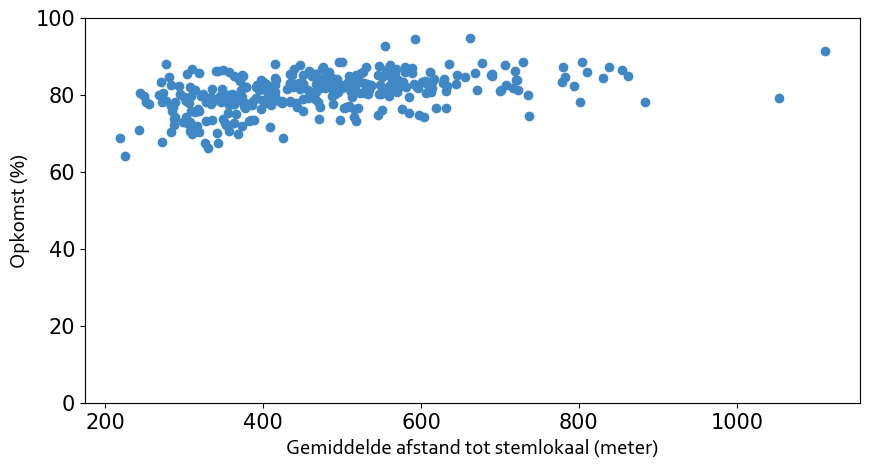

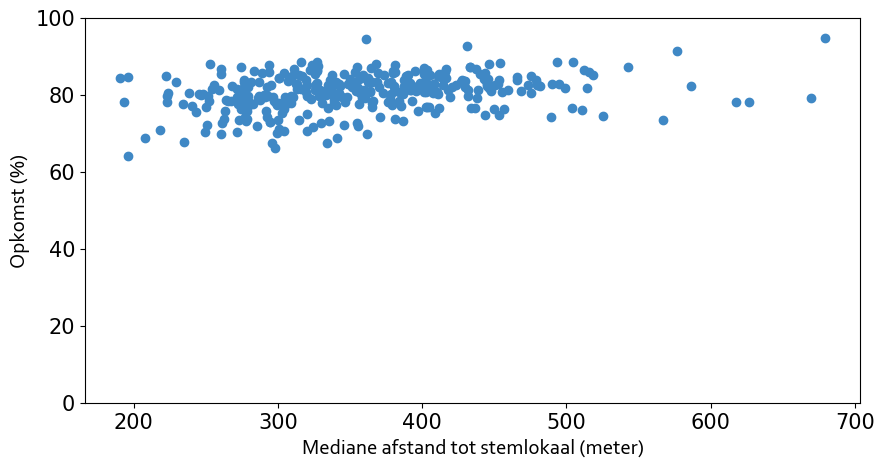

Correlation between is dist_mean and turn up is 0.40944627378398013
Correlation between is dist_median and turn up is 0.32237527926023757


In [81]:
# Define fontdict
fontdict = {
    'fontname': "Corbel",
    'fontsize': 15
}

plt.rcParams["figure.figsize"] = [10,5]
plt.scatter(turn_up_vs_distance['dist_mean'],turn_up_vs_distance['Fraction_turn_up'],color = '#3f88c5')
plt.ylim(0, 100)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Gemiddelde afstand tot stemlokaal (meter)',fontdict= fontdict) #color = ['navy']
#plt.xlabel('Gemiddelde afstand tot stemlokaal (meter)', fontsize=15, fontdict={'fontname': "Segoe UI"})
plt.ylabel('Opkomst (%)',fontdict= fontdict)
#plt.savefig("G://Projecten//Data Science//8577_Meting Stemlokalen Tweede Kamer 2023//Results\Graphs//Dist_meanVsVoting_gemeente.svg", format='svg',bbox_inches = 'tight')
plt.savefig("G://Projecten//Data Science//8577_Meting Stemlokalen Tweede Kamer 2023//Results//Graphs//Dist_meanVsVoting_gemeente.png", format='png', dpi=500,bbox_inches = 'tight',transparent = True)
plt.show()

plt.rcParams["figure.figsize"] = [10,5]
plt.scatter(turn_up_vs_distance['dist_median'],turn_up_vs_distance['Fraction_turn_up'],color = '#3f88c5') #color = ['navy']
plt.ylim(0, 100)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Mediane afstand tot stemlokaal (meter)',fontdict= fontdict)
#plt.xlabel('Mediane afstand tot stemlokaal (meter)', fontsize=15, fontdict={'fontname': "Segoe UI"})
plt.ylabel('Opkomst (%)',fontdict= fontdict)
#plt.savefig("G://Projecten//Data Science//8577_Meting Stemlokalen Tweede Kamer 2023//Results//Graphs//Dist_medianVsVoting_gemeente_median.svg", format='svg',bbox_inches = 'tight')
plt.savefig("G://Projecten//Data Science//8577_Meting Stemlokalen Tweede Kamer 2023//Results//Graphs//Dist_medianVsVoting_gemeente_median.png", format='png', dpi=500,bbox_inches = 'tight', transparent = True)
plt.show()
#
# correlation 
corr = turn_up_vs_distance['dist_mean'].corr(turn_up_vs_distance['Fraction_turn_up'])
print("Correlation between is dist_mean and turn up is {}".format(corr))

corr = turn_up_vs_distance['dist_median'].corr(turn_up_vs_distance['Fraction_turn_up'])
print("Correlation between is dist_median and turn up is {}".format(corr))

In [82]:
# Remove 'Schiermonnikoog' from the dataset
turn_up_vs_distance_wo_Schiermonnikoog = turn_up_vs_distance[turn_up_vs_distance['gemeente'] != 'Schiermonnikoog']

# Calculate and print the correlation between mean distance and turnout fraction
mean_distance_corr = turn_up_vs_distance_wo_Schiermonnikoog['dist_mean'].corr(turn_up_vs_distance_wo_Schiermonnikoog['Fraction_turn_up'])
print(f"Correlation between dist_mean and turn up is {mean_distance_corr:.5f}")

# Calculate and print the correlation between median distance and turnout fraction
median_distance_corr = turn_up_vs_distance_wo_Schiermonnikoog['dist_median'].corr(turn_up_vs_distance_wo_Schiermonnikoog['Fraction_turn_up'])
print(f"Correlation between dist_median and turn up is {median_distance_corr:.5f}")


Correlation between dist_mean and turn up is 0.44222
Correlation between dist_median and turn up is 0.33740


In [83]:
# Calculate and print Pearson correlation coefficient and p-value for mean distance and turnout fraction
mean_distance_pearsonr = pearsonr(turn_up_vs_distance['dist_mean'], turn_up_vs_distance['Fraction_turn_up'])
print(f"Pearson correlation (mean distance and turnout): Coefficient = {mean_distance_pearsonr[0]:.3f}, p-value = {mean_distance_pearsonr[1]:.3g}")

# Calculate and print Pearson correlation coefficient and p-value for median distance and turnout fraction
median_distance_pearsonr = pearsonr(turn_up_vs_distance['dist_median'], turn_up_vs_distance['Fraction_turn_up'])
print(f"Pearson correlation (median distance and turnout): Coefficient = {median_distance_pearsonr[0]:.3f}, p-value = {median_distance_pearsonr[1]:.3g}")


Pearson correlation (mean distance and turnout): Coefficient = 0.409, p-value = 2.95e-15
Pearson correlation (median distance and turnout): Coefficient = 0.322, p-value = 1.04e-09


In [84]:
## Analyse by gemeente sizes

# Convert 'inwoners' column to integer
turn_up_vs_distance.inwoners = turn_up_vs_distance.inwoners.astype(int)

# Classify municipality based on the number of inhabitants
Type = ['Kleine' if s < 40000 else 'Grote' if s > 150000 else 'Middelgrote' for s in turn_up_vs_distance.inwoners]
turn_up_vs_distance['municipality_type'] = list(Type)


In [85]:
for gm_size in turn_up_vs_distance.municipality_type.unique():
    turn_up_vs_distance_size = turn_up_vs_distance[turn_up_vs_distance.municipality_type==gm_size]
    print(f"Size of {gm_size} : {len(turn_up_vs_distance_size)}")
    # Calculate and print Pearson correlation coefficient and p-value for mean distance and turnout fraction
    mean_distance_pearsonr = pearsonr(turn_up_vs_distance_size['dist_mean'], turn_up_vs_distance_size['Fraction_turn_up'])
    print(f"Pearson correlation (mean distance and turnout): Coefficient = {mean_distance_pearsonr[0]:.3f}, p-value = {mean_distance_pearsonr[1]:.3g},size  = {gm_size}")

    # Calculate and print Pearson correlation coefficient and p-value for median distance and turnout fraction
    median_distance_pearsonr = pearsonr(turn_up_vs_distance_size['dist_median'], turn_up_vs_distance_size['Fraction_turn_up'])
    print(f"Pearson correlation (median distance and turnout): Coefficient = {median_distance_pearsonr[0]:.3f}, p-value = {median_distance_pearsonr[1]:.3g}, size  = {gm_size}")

Size of Kleine : 207
Pearson correlation (mean distance and turnout): Coefficient = 0.201, p-value = 0.00375,size  = Kleine
Pearson correlation (median distance and turnout): Coefficient = 0.149, p-value = 0.0316, size  = Kleine
Size of Middelgrote : 117
Pearson correlation (mean distance and turnout): Coefficient = 0.504, p-value = 7.14e-09,size  = Middelgrote
Pearson correlation (median distance and turnout): Coefficient = 0.287, p-value = 0.00169, size  = Middelgrote
Size of Grote : 18
Pearson correlation (mean distance and turnout): Coefficient = 0.204, p-value = 0.417,size  = Grote
Pearson correlation (median distance and turnout): Coefficient = 0.140, p-value = 0.579, size  = Grote


In [91]:
turn_up_vs_distance.municipality_type.unique()

array(['Kleine', 'Middelgrote', 'Grote'], dtype=object)

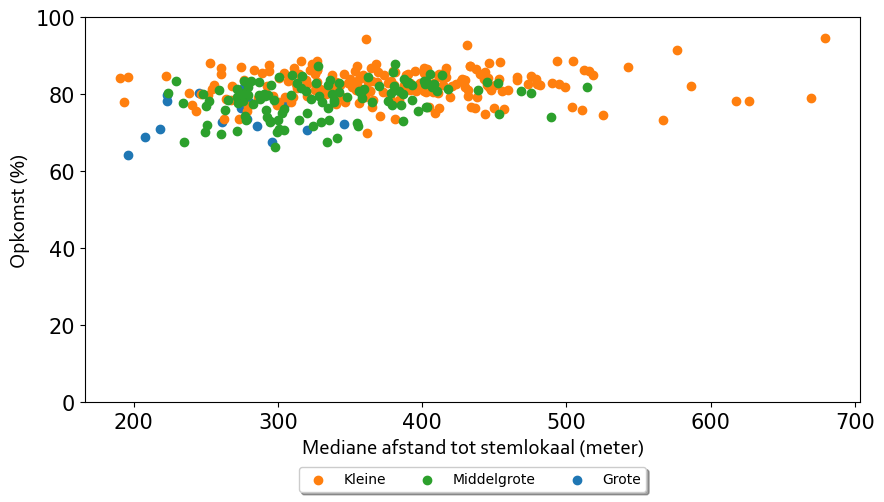

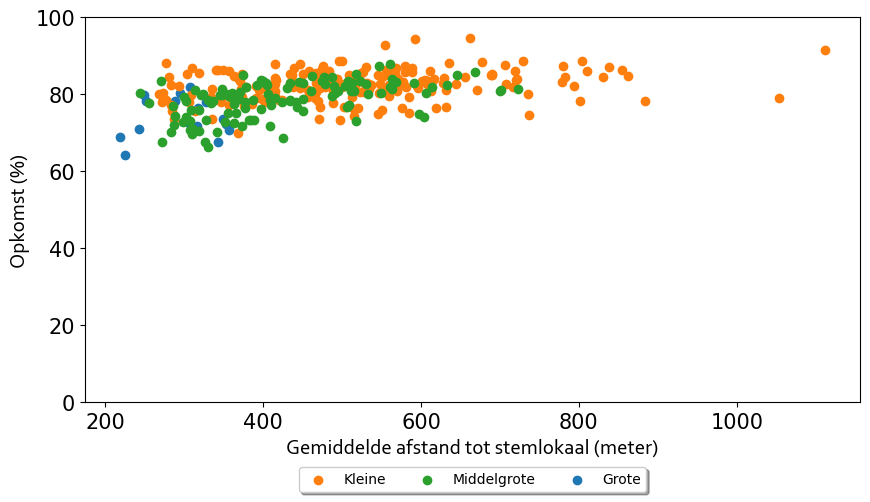

In [118]:
plt.rcParams["figure.figsize"] = [10, 5]

# Function to plot scatter plots for 'dist_median' and 'dist_mean' against 'Fraction_turn_up'
def plot_turn_up_vs_distance(data, x_column, x_label, file_name):
    fig, ax = plt.subplots()  # Create a figure and axis object

    # Iterate over each 'municipality_type' to scatter plot with different colors
    for municipality_type, group in data.groupby('municipality_type'):
        ax.scatter(group[x_column], group['Fraction_turn_up'], label=municipality_type)
    
    # Sort the legend labels
    handles, labels = ax.get_legend_handles_labels()
    desired_order = ['Kleine', 'Middelgrote', 'Grote']
    ordered_handles = [handles[labels.index(label)] for label in desired_order]
    ordered_labels = [label for label in desired_order]

    # Create legend with the specified order and custom settings
    ax.legend(ordered_handles, ordered_labels, loc='upper center', bbox_to_anchor=(0.5, -0.15),
              fancybox=True, shadow=True, ncol=3)
    
    # Set plot limits and labels with custom fonts
    plt.ylim(0, 100)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel(x_label, fontdict=fontdict)
    plt.ylabel('Opkomst (%)', fontdict=fontdict)
    
    # Save the plot to a file
    plt.savefig(f"G://Projecten//Data Science//8577_Meting Stemlokalen Tweede Kamer 2023//Results//Graphs//{file_name}", format='png', dpi=500, bbox_inches='tight', transparent=True)
    plt.show()

# Plot for median distance
plot_turn_up_vs_distance(turn_up_vs_distance, 'dist_median', 'Mediane afstand tot stemlokaal (meter)', 'Dist_medianVsVoting_gemeenteSize.png')

# Plot for mean distance
plot_turn_up_vs_distance(turn_up_vs_distance, 'dist_mean', 'Gemiddelde afstand tot stemlokaal (meter)', 'Dist_meanVsVoting_gemeenteSize.png')
